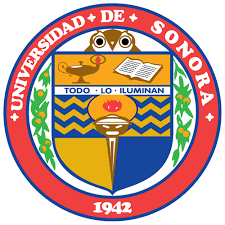



# **Actividad 6**

*Pronóstico de Series de Tiempo*

Iveth Rocio Navarro Lopez



---

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf 

---
**Preliminares**






In [72]:
#Creación de DATA FRAME dela base de datos y uno adicional para trabajar

url= "https://raw.githubusercontent.com/novandromeda-a/Computational-physics/master/Actividad%201/Base%20de%20datos%20climatol%C3%B3gica.txt"

e=["Fecha","Precip","Evap","Tmax","Tmin"] #Encabezados de las columnas en la 
                                          #base de datos

df_weather = pd.read_csv(url, names=e, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')                                          
#Declaración de DATA FRAME

#print(df_weather.head(10)) 
#print(df_weather.tail(10)) 
#df_weather.shape  
#df_weather.info()

df_weather1=df_weather.copy() #Este data frame será con el que trabajemos
df_weather1.head()

str_Nulo='Nulo'
df_weather2=df_weather1.replace(to_replace=str_Nulo, value=' ', regex=True) 
df_weather2.head()

#Las siguientes lineas son para pasar los datos a numéricos
cols_list=["Precip","Evap","Tmax","Tmin"] #Diccionario para loop for
for cols in cols_list:
  df_weather2[cols]=pd.to_numeric(df_weather2[cols], errors='coerce') 

#df_weather2.info() 

#Las siguientes lienas sirven para un conteo de datos faltantes
#df_weather2.isnull().sum() 

#df_weather2.head()
#df_weather2.tail()

#df_weather2.describe() #Esta línea sirve para el análisis estadístico

#Las siguientes lineas sirven para hacer que Python reconozca el formato de fecha
df_weather3=df_weather2.copy() 
#df_weather3['Fecha'].head() 

df_weather3['Fecha']=pd.to_datetime(df_weather3['Fecha'], dayfirst=True).copy() 
#df_weather3['Fecha'].head()
#df_weather3.dtypes 

df_weather3['Año']=df_weather3['Fecha'].dt.year 
df_weather3['Mes']=df_weather3['Fecha'].dt.month 

#df_weather3.head()
#df_weather3.tail()

df_weather3.info() 

df_weather4=df_weather3.copy()

df_weather5=df_weather4.copy()
df_weather5=df_weather5.set_index('Fecha')

#print(df_weather5.head())

# Periodos de 30 años
df_weather530=df_weather5[(df_weather5['Año'] >= 1952) & (df_weather5['Año'] <= 1972)]
df_weather560=df_weather5[(df_weather5['Año'] > 1972) & (df_weather5['Año'] <= 2002)]
df_weather590=df_weather5[(df_weather5['Año'] > 2002) & (df_weather5['Año'] <= 2015)]
df_weather5a=df_weather5[(df_weather5['Año'] >= 1990) & (df_weather5['Año'] <= 2015)]

#df_weather530.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17602 entries, 0 to 17601
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fecha   17602 non-null  datetime64[ns]
 1   Precip  17568 non-null  float64       
 2   Evap    9008 non-null   float64       
 3   Tmax    16608 non-null  float64       
 4   Tmin    16648 non-null  float64       
 5   Año     17602 non-null  int64         
 6   Mes     17602 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 962.7 KB


---
**Actividad 6.1**







Precip       0
Evap      1034
Tmax         0
Tmin         0
Año          0
Mes          0
dtype: int64
            Precip  Evap  Tmax  Tmin   Año  Mes
Fecha                                          
1973-01-01     0.0   NaN  14.0   2.0  1973    1
1973-01-02     0.0   NaN  17.0   3.0  1973    1
1973-01-03     0.0   NaN  18.0   5.0  1973    1
1973-01-04     0.0   NaN  19.0   9.0  1973    1
1973-01-05     0.0   NaN  16.0   4.0  1973    1


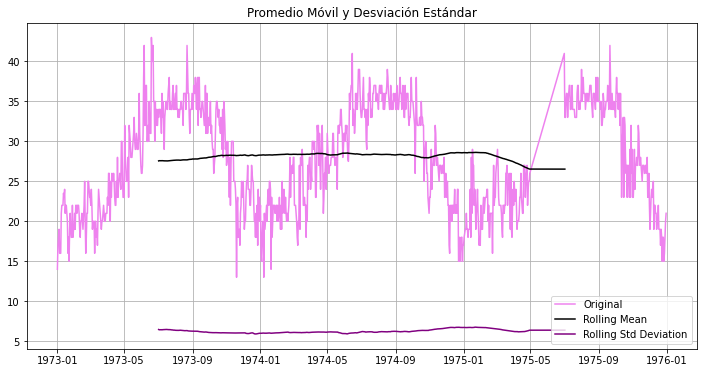

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -1.986570
p-value                           0.292492
#Lags Used                       12.000000
Number of Observations Used    1021.000000
Critical Value (1%)              -3.436771
Critical Value (5%)              -2.864375
Critical Value (10%)             -2.568279
dtype: float64


In [73]:
#La siguiente secuencia de códigos sirve para probar si una serie determinada es
#una serie de tiempo estacionaria o, en su defecto, hacer las transformaciones 
#para convertirla en una. 

# Función para probar la estacionaria de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts): 
     #Determinar la Estadística de promedios móviles
     rolmean = df_ts.rolling(window=365, center=True).mean()
     rolstd = df_ts.rolling(window=365, center=True).std()

     # Define el tamaño de la figura
     plt.rcParams["figure.figsize"] = (12,6)

     #Graficar la Estadística de promedios móviles
     plt.plot(df_ts, color='violet',label='Original')
     plt.plot(rolmean, color='black', label='Rolling Mean')
     plt.plot(rolstd, color='purple', label = 'Rolling Std Deviation')
     plt.legend(loc='best')
     plt.title('Promedio Móvil y Desviación Estándar')
     plt.grid()
     plt.show()

     #Realiza la Prueba Aumentada de Dickey-Fuller:
     print('Resultados de la Prueba de Dickey-Fuller:')
     dftest = adfuller(df_ts, autolag='AIC')
     dfoutput = pd.Series(dftest[0:4],
          index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
     for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value

     print(dfoutput)

# Serie elegida
start, end = '1972-01', '1975-12'

ts_60 = df_weather560.loc[start:end].copy()
ts_60.head()
print(ts_60.isnull().sum())
print(ts_60.head())
#Serie de tiempo de la variable deseada:
ts_WTmaxtest=ts_60['Tmax'].copy()
#ts_WTmaxtest.head()

test_stationarity(ts_WTmaxtest)

Observación: el valor de p es mayor que 0.05, por lo que habrá que reducir su tendencia.

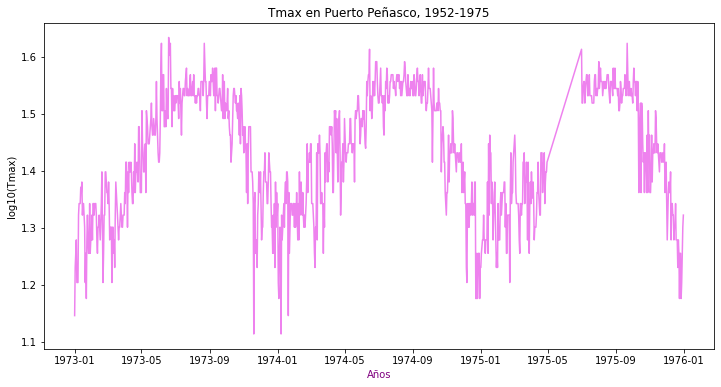

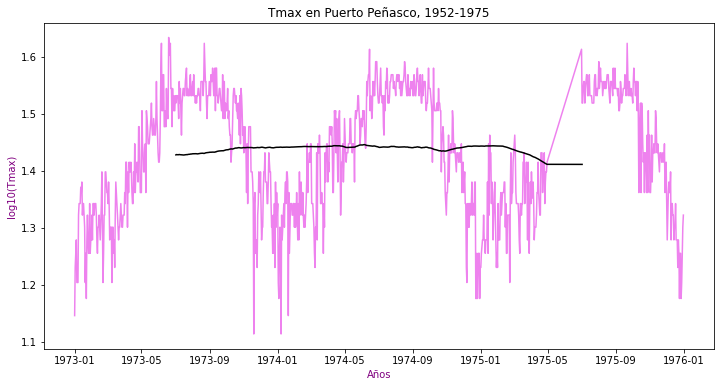

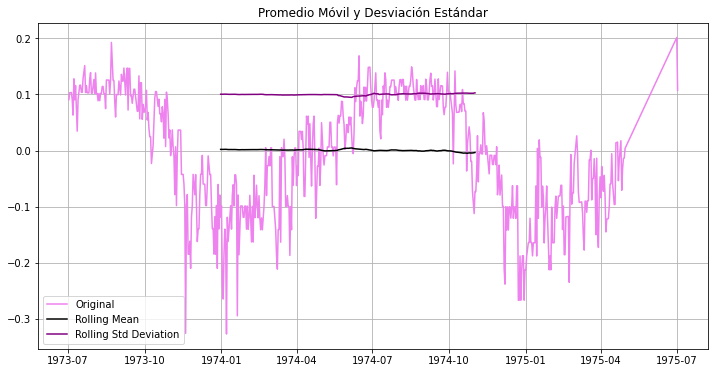

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                  -1.876319
p-value                          0.343282
#Lags Used                      19.000000
Number of Observations Used    650.000000
Critical Value (1%)             -3.440450
Critical Value (5%)             -2.865997
Critical Value (10%)            -2.569143
dtype: float64


In [74]:
#Vamos a reducir la escala usando una escala logarítmica
ts_WTmaxtest_log10=np.log10(ts_WTmaxtest)
plt.plot(ts_WTmaxtest_log10, color='violet')
plt.xlabel('Años',color='purple')
plt.ylabel('log10(Tmax)', color='black')
plt.title('Tmax en Puerto Peñasco, 1952-1975')
plt.show()

#Promedio movible de 365 días
M365WTmaxtest=ts_WTmaxtest_log10.rolling(365, center=True).mean()

ts_WTmaxtest_log10=np.log10(ts_WTmaxtest)
plt.plot(ts_WTmaxtest_log10, color='violet')
plt.xlabel('Años',color='purple')
plt.ylabel('log10(Tmax)', color='purple')
plt.plot(M365WTmaxtest, color='black')
plt.title('Tmax en Puerto Peñasco, 1952-1975')
plt.show()

# Ahora haremos la diferencia del logarítmo y el promedio
ts_WTmaxtest_log10_Av_diff=ts_WTmaxtest_log10-M365WTmaxtest
ts_WTmaxtest_log10_Av_diff.dropna(inplace=True)
ts_WTmaxtest_log10_Av_diff.head()

#Estacionaridad de la serie con escala logarítmica:
test_stationarity(ts_WTmaxtest_log10_Av_diff)

Observación: El valor de p sigue siendo mayor que 0.05, por lo que se seguirá
reduciendo en el siguiente código.

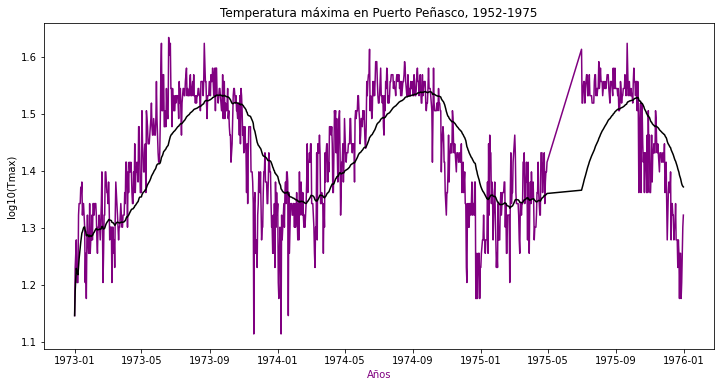

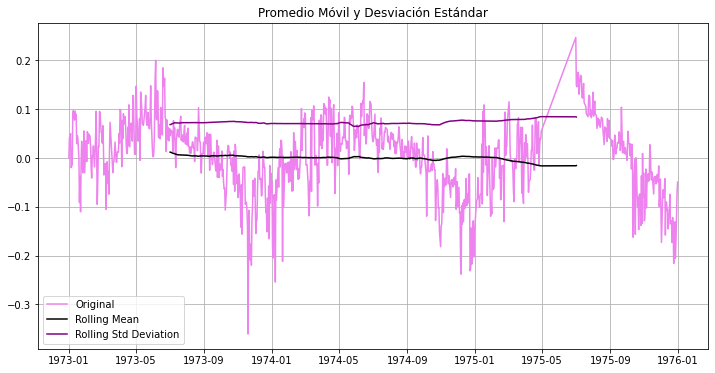

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.298482
p-value                           0.172458
#Lags Used                       16.000000
Number of Observations Used    1017.000000
Critical Value (1%)              -3.436796
Critical Value (5%)              -2.864386
Critical Value (10%)             -2.568285
dtype: float64


In [75]:
ts_WTmaxtest_log10EWM=ts_WTmaxtest_log10.ewm(halflife=30).mean()

plt.plot(ts_WTmaxtest_log10,color='purple')
plt.plot(ts_WTmaxtest_log10EWM, color='black')
plt.xlabel('Años',color='purple')
plt.ylabel('log10(Tmax)',color='black')
plt.title('Temperatura máxima en Puerto Peñasco, 1952-1975')
plt.show()

ts_WTmaxtest_log10_EWM_diff=ts_WTmaxtest_log10-ts_WTmaxtest_log10EWM

test_stationarity(ts_WTmaxtest_log10_EWM_diff)

Observación, el último valor de p es el más cercano a 0.05 que se pudo obtener hasta ahora.

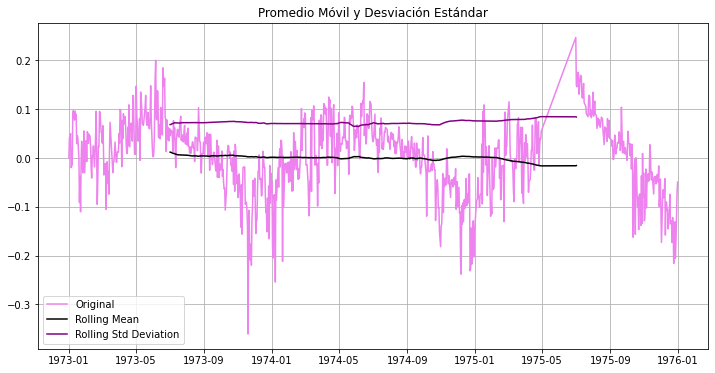

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.298482
p-value                           0.172458
#Lags Used                       16.000000
Number of Observations Used    1017.000000
Critical Value (1%)              -3.436796
Critical Value (5%)              -2.864386
Critical Value (10%)             -2.568285
dtype: float64


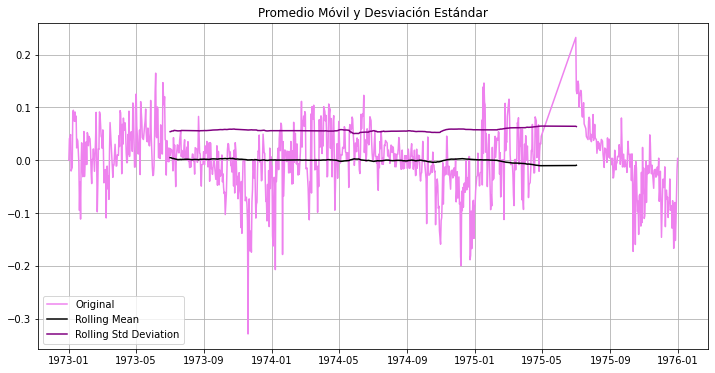

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.518342
p-value                           0.007528
#Lags Used                       16.000000
Number of Observations Used    1017.000000
Critical Value (1%)              -3.436796
Critical Value (5%)              -2.864386
Critical Value (10%)             -2.568285
dtype: float64


In [76]:
ts_WTmaxtest_log10EWM=ts_WTmaxtest_log10.ewm(halflife=30).mean()
ts_WTmaxtest_log10_EWM_diff=ts_WTmaxtest_log10-ts_WTmaxtest_log10EWM

test_stationarity(ts_WTmaxtest_log10_EWM_diff)


ts_WTmaxtest_log10EWM=ts_WTmaxtest_log10.ewm(halflife=15).mean()
ts_WTmaxtest_log10_EWM_diff=ts_WTmaxtest_log10-ts_WTmaxtest_log10EWM

test_stationarity(ts_WTmaxtest_log10_EWM_diff)

Observación: Aquí ya pudimos obtener un valor de p menor que 0.05.

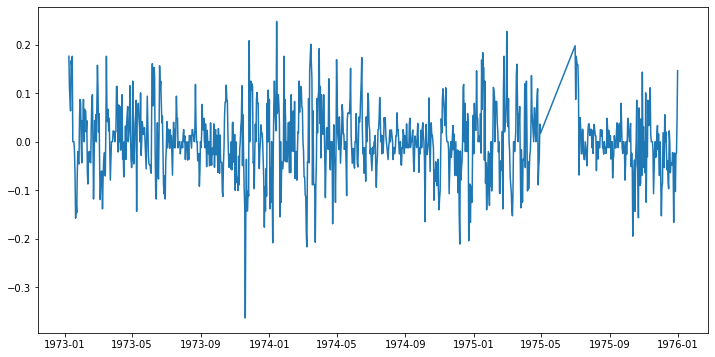

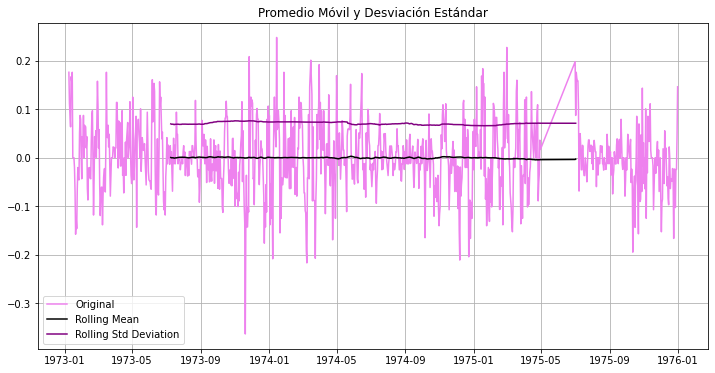

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -6.116969e+00
p-value                        9.045594e-08
#Lags Used                     2.200000e+01
Number of Observations Used    1.004000e+03
Critical Value (1%)           -3.436880e+00
Critical Value (5%)           -2.864423e+00
Critical Value (10%)          -2.568305e+00
dtype: float64


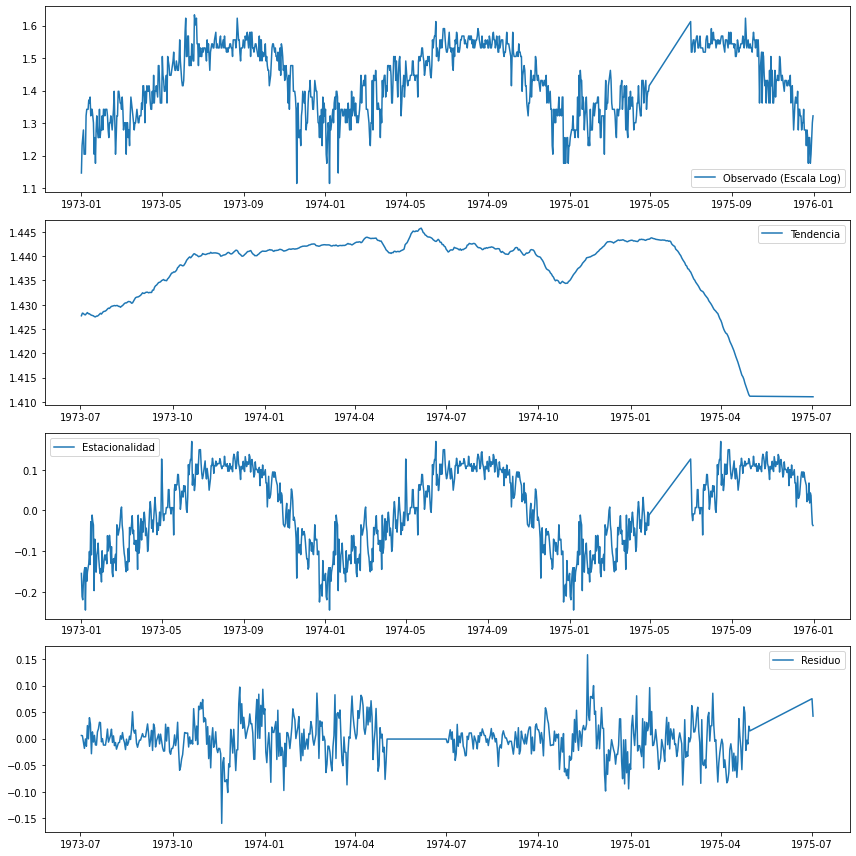

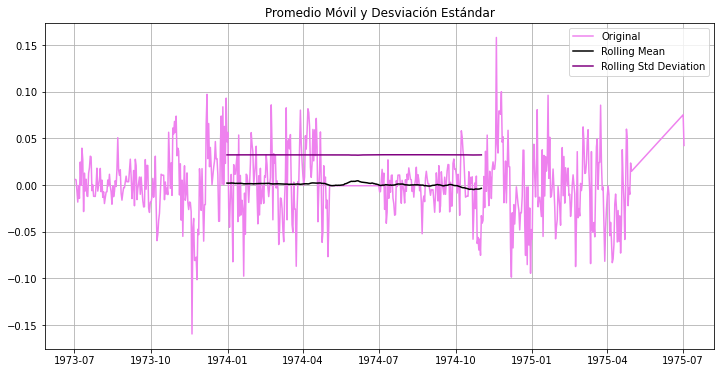

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -6.857718e+00
p-value                        1.632203e-09
#Lags Used                     1.900000e+01
Number of Observations Used    6.500000e+02
Critical Value (1%)           -3.440450e+00
Critical Value (5%)           -2.865997e+00
Critical Value (10%)          -2.569143e+00
dtype: float64


In [77]:
#Eliminando la estacionalidad de los datos.
#.shift():

ts_WTmaxtest_log10_shft=ts_WTmaxtest_log10.shift(periods=7)

ts_WTmaxtest_log10_shftdiff=ts_WTmaxtest_log10-ts_WTmaxtest_log10_shft
plt.plot(ts_WTmaxtest_log10_shftdiff)
plt.show()

ts_WTmaxtest_log10_shftdiff.dropna(inplace=True)
test_stationarity(ts_WTmaxtest_log10_shftdiff)


#statsmodels.tsa

DTmaxlog = sm.tsa.seasonal_decompose(ts_WTmaxtest_log10.interpolate(), model='additive', freq=365)

trend = DTmaxlog.trend
seasonal = DTmaxlog.seasonal
residue = DTmaxlog.resid

plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_WTmaxtest_log10, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

plt.tight_layout();
plt.show()

#Test de la gráfica de residuo, eliminando Tendencia y Estacinoalidad
ts_WTmaxtest_logresid=residue
ts_WTmaxtest_logresid.dropna(inplace=True)
test_stationarity(ts_WTmaxtest_logresid)



---

**Actividad 6.2**

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


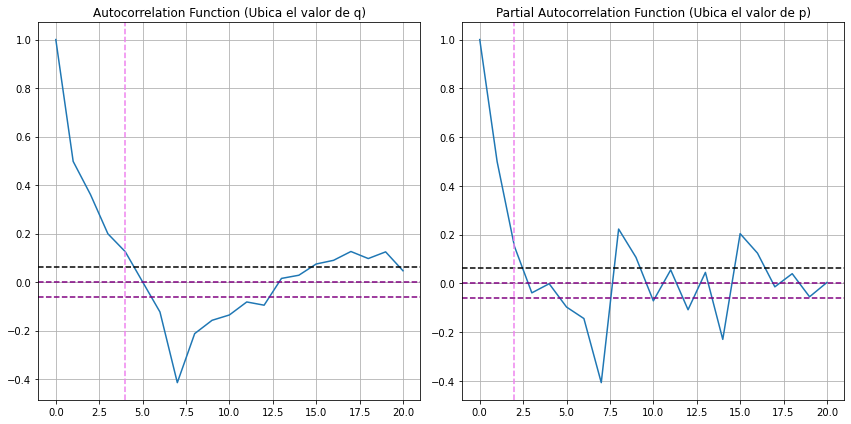

In [78]:
#La siguiente secuencia de datos sirve para construir los modelos ARIMA para
#cada Temperatura (Tmax y Tmin), y contrastar la bondad del ajuste en cada caso,
#calculando el error de la raíz cuadrada promedio RMSE y sobreponiendo 
#gráficamente ambas series, la observada y la construida con el método ARIMA.

lag_acf = acf(ts_WTmaxtest_log10_shftdiff, nlags=20)
lag_pacf = pacf(ts_WTmaxtest_log10_shftdiff, nlags=20, method = 'ols')

plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='purple')
plt.axhline(y=-1.96/np.sqrt(len(ts_WTmaxtest_log10_shftdiff)), linestyle='--', color='purple')
plt.axhline(y=1.96/np.sqrt(len(ts_WTmaxtest_log10_shftdiff)), linestyle='--', color='black')
# Graficamos unas líneas verticales como referencias
plt.axvline(x=4, linestyle='--', color='violet')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='purple')
plt.axhline(y=-1.96/np.sqrt(len(ts_WTmaxtest_log10_shftdiff)), linestyle='--', color='purple')
plt.axhline(y=1.96/np.sqrt(len(ts_WTmaxtest_log10_shftdiff)), linestyle='--', color='black')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='violet')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1033
Model:                 ARIMA(4, 1, 0)   Log Likelihood                1771.874
Method:                       css-mle   S.D. of innovations              0.044
Date:                Thu, 25 Feb 2021   AIC                          -3531.748
Time:                        05:10:32   BIC                          -3502.107
Sample:                             1   HQIC                         -3520.500
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          9.62e-05      0.001      0.138      0.890      -0.001       0.001
ar.L1.D.Tmax    -0.4592      0.031    -14.744      0.000      -0.520      -0.398
ar.L2.D.Tmax    -0.2353      0.034     -6.95

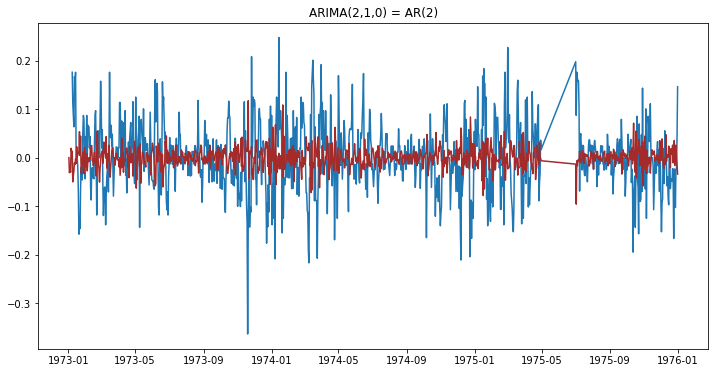

In [79]:
#Modelo de autoregresión
#Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_WTmaxtest_log10, order=(4,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_WTmaxtest_log10_shftdiff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1033
Model:                 ARIMA(0, 1, 2)   Log Likelihood                1775.231
Method:                       css-mle   S.D. of innovations              0.043
Date:                Thu, 25 Feb 2021   AIC                          -3542.462
Time:                        05:10:32   BIC                          -3522.701
Sample:                             1   HQIC                         -3534.964
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         7.415e-05      0.001      0.134      0.893      -0.001       0.001
ma.L1.D.Tmax    -0.4933      0.030    -16.302      0.000      -0.553      -0.434
ma.L2.D.Tmax    -0.0989      0.033     -3.03

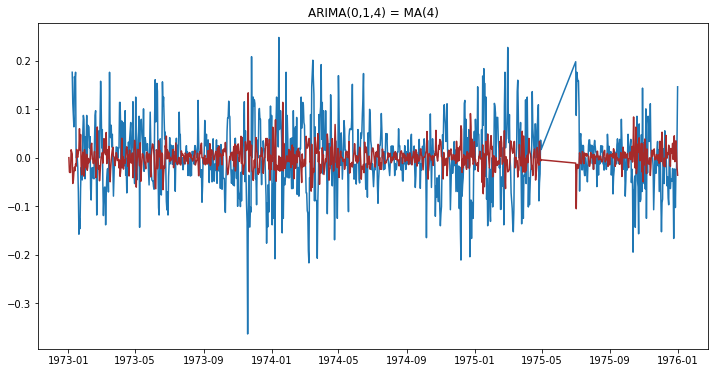

In [80]:
#Módelo Moving Average (Promedio movible)
#Modelo MA(q): (p,d,q) = (0,1,2) 
model = ARIMA(ts_WTmaxtest_log10, order=(0,1,2), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_WTmaxtest_log10_shftdiff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1033
Model:                 ARIMA(4, 1, 2)   Log Likelihood                1787.447
Method:                       css-mle   S.D. of innovations              0.043
Date:                Thu, 25 Feb 2021   AIC                          -3558.894
Time:                        05:10:34   BIC                          -3519.372
Sample:                             1   HQIC                         -3543.896
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4.123e-05      0.000      0.112      0.911      -0.001       0.001
ar.L1.D.Tmax    -0.1119      0.226     -0.494      0.621      -0.556       0.332
ar.L2.D.Tmax     0.3278      0.092      3.57

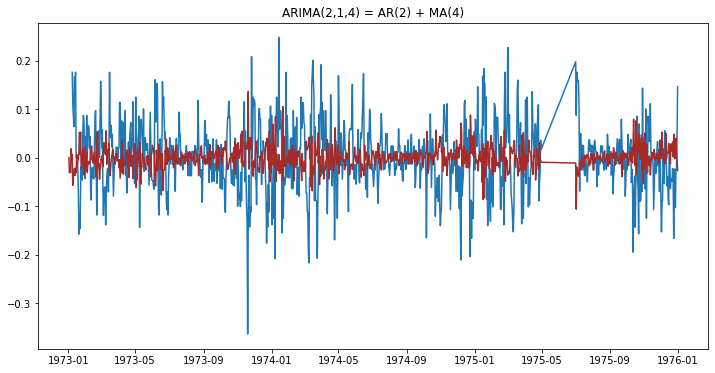

In [81]:
#Modelo ARIMA (MA + AR):
#Modelo ARIMA(p): (p,d,q) = (2,1,2) 
model = ARIMA(ts_WTmaxtest_log10, order=(4,1,2), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_WTmaxtest_log10_shftdiff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

Observación: Podemos observar que, según su AIC, el modelo ARIMA (MA + AR) es el mejor.

Fecha
1973-01-02    0.000041
1973-01-03   -0.031021
1973-01-04   -0.023313
1973-01-05   -0.030529
1973-01-06    0.018515
                ...   
1975-12-27    0.006358
1975-12-28    0.039880
1975-12-29    0.017267
1975-12-30   -0.008319
1975-12-31   -0.026671
Length: 1033, dtype: float64
Fecha
1973-01-01         NaN
1973-01-02    1.230490
1973-01-03    1.224252
1973-01-04    1.255441
1973-01-05    1.173591
dtype: float64
Fecha
1975-12-27    1.182450
1975-12-28    1.244000
1975-12-29    1.272540
1975-12-30    1.292711
1975-12-31    1.295548
dtype: float64


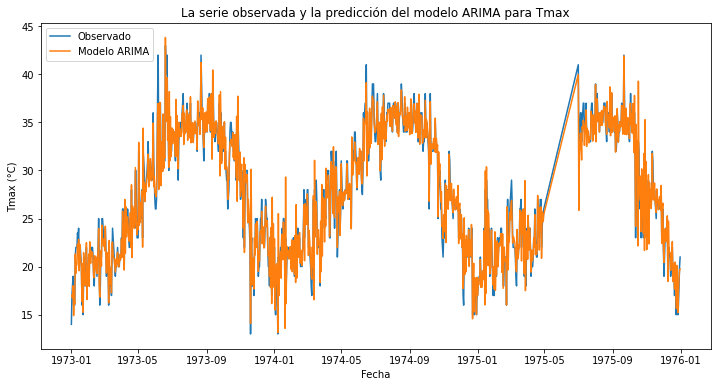

In [82]:
PREARIMA = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(PREARIMA)

LOGARIMA = pd.Series(ts_WTmaxtest_log10, index = ts_WTmaxtest_log10.index)
LOGARIMA = LOGARIMA.add(PREARIMA)
print(LOGARIMA.head())
print(LOGARIMA.tail())

PREARIMA0 = 10**(LOGARIMA)

plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_WTmaxtest, label='Observado');
plt.plot(PREARIMA0, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (°C)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

RMSE: 1.3072742691311097


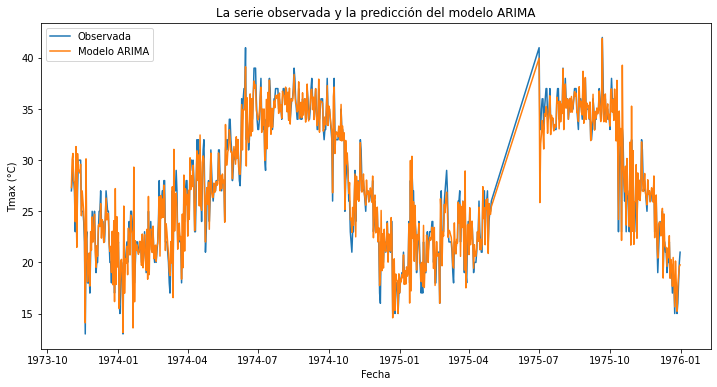

In [83]:
RMSE = np.sqrt(np.mean((PREARIMA0 - ts_WTmaxtest)**2))
print('RMSE:', RMSE)

ts_WTmaxtest0 = ts_WTmaxtest.tail(730)
PREARIMA1 = PREARIMA0.tail(730)
plt.plot(ts_WTmaxtest0, label='Observada');
plt.plot(PREARIMA1, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (°C)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');